<a href="https://colab.research.google.com/github/AndyMDH/pneumonia_detection_cnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506  End of Module: Pneumonia Detection through Convolutional Neural Network (CNN)



## Table of Contents
1. [Introduction](#section-1)
2. [Exploratory Data Analysis](#section-2)
3. [Data Preprocessing and Augmentation](#section-3)
4. [CNN Architecture Development](#section-4)
5. [Model Evaluation](#section-5)
6. [Summary & Retrospective](#section-6)
7. [References](#section-7)

---
## Introduction

Pneumonia poses a severe threat to human health, being a potentially life-threatening infectious illness that typically affects one or both lungs. It is frequently triggered by bacteria, notably Streptococcus pneumoniae. According to the World Health Organization (WHO), pneumonia is responsible for one in three deaths in India (Varshni et al., 2019). Medical practitioners often rely on X-ray scans to diagnose pneumonia, distinguishing between bacterial and viral types.

This Jupyter notebook delves into the realm of automated pneumonia detection using Convolutional Neural Networks (CNNs). Specifically, it addresses the task of training a CNN model to differentiate between healthy lung scans and those afflicted with pneumonia. The dataset utilised for this endeavor is sourced from the Kaggle competition repository, offering a collection of chest X-ray images categorised as pneumonia-positive and normal.


**This task involves, but is not limited to:**

a. CNN Model Development:

- Write code to train a CNN model using the provided dataset.
- Objective: Achieve optimal performance in distinguishing between healthy and pneumonia-infected lung images.

    - **Key considerations:**
      - Define CNN architecture, including convolution-pooling blocks.
      - Fine-tune parameters like strides, padding, and activation functions for accuracy.
      - Implement strategies to prevent overfitting and ensure model generalization.

b. Training and Evaluation:

- Train the CNN model using the provided training dataset.
Fine-tune hyperparameters using validation data to enhance performance.
- Evaluate the model's accuracy using a separate test dataset to validate pneumonia detection in chest X-ray images.

This Jupyter Notebook was collaboratively prepared by:

- Minh-Dat Andy Ho Huu
- Santiago Fernandez Blanco
- Ismael Saumtally
- Chi Chuen Wan
- Chui Yi Wong

### Import Dependencies

In [1]:
# Standard library imports
import logging
import os
import unicodedata
from collections import defaultdict
from typing import List, Optional, Set, Tuple
from zipfile import ZipFile
import random

# Related third party imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive

# Warnings configuration
import warnings

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. If you don't have a GPU, set this to False.

In [2]:
USE_CUDA = True

In [3]:
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Download Pneumonia Dataset

The Corpus can be downloaded here: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)

In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Load Dataset into DataFrame from Google Drive

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Defining dataset directory
DATASET_DIR = "/content/drive/MyDrive/Liverpool/CSCK506 Deep Learning/End of Module/archive/chest_xray"
train_dir = DATASET_DIR + "/train"
val_dir = DATASET_DIR + "/val"
test_dir = DATASET_DIR + "/test"

if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
    print("Dataset directories exist.")
else:
    print("One or more dataset directories are not found. Please recheck the file locations.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directories exist.


**Alternatively**, if you want to run this notebook from your local machine, you can run the code block below to download and unzip the x-ray files from Kaggle.

In [6]:
# def download_file(url, destination):
#     try:
#         urllib.request.urlretrieve(url, destination)
#         logger.info(f'Downloaded file from {url} to {destination}')
#     except Exception as e:
#         logger.error(f'Error downloading file: {e}')

# def extract_zip(zip_path, extract_path):
#     try:
#         with ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         logger.info(f'Extracted {zip_path} to {extract_path}')
#     except Exception as e:
#         logger.error(f'Error extracting zip file: {e}')

# def create_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         logger.info(f'Created directory: {directory}')

# DATASET_NAME = 'chest_x_ray'
# DATASET_URL = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download'
# DATASET_DIR = os.path.join(DATASET_NAME)
# DATASET_ZIP = os.path.join(DATASET_DIR, 'archive.zip')

# # Check if dataset directory already exists
# if os.path.exists(DATASET_DIR):
#     print(f'{DATASET_NAME} already exists')
# else:
#     if os.path.exists(DATASET_ZIP):
#         create_directory(DATASET_DIR)
#         extract_zip(DATASET_ZIP, CORPUS_DIR)
#         os.remove(DATASET_ZIP)
#         print(f'{DATASET_URL_NAME} extracted')
#     else:
#         print(f'To obtain the "{DATASET_NAME}" dataset, please follow these steps:')
#         print(f'1. Manually download the WikiQA dataset from: {DATASET_URL}')
#         print(f'2. Place the downloaded "archive.zip" file in the "{DATASET_DIR}" folder.')
#         print(f'3. Rerun this script after placing the corpus in the correct location.')


---
## Exploratory Data Analysis

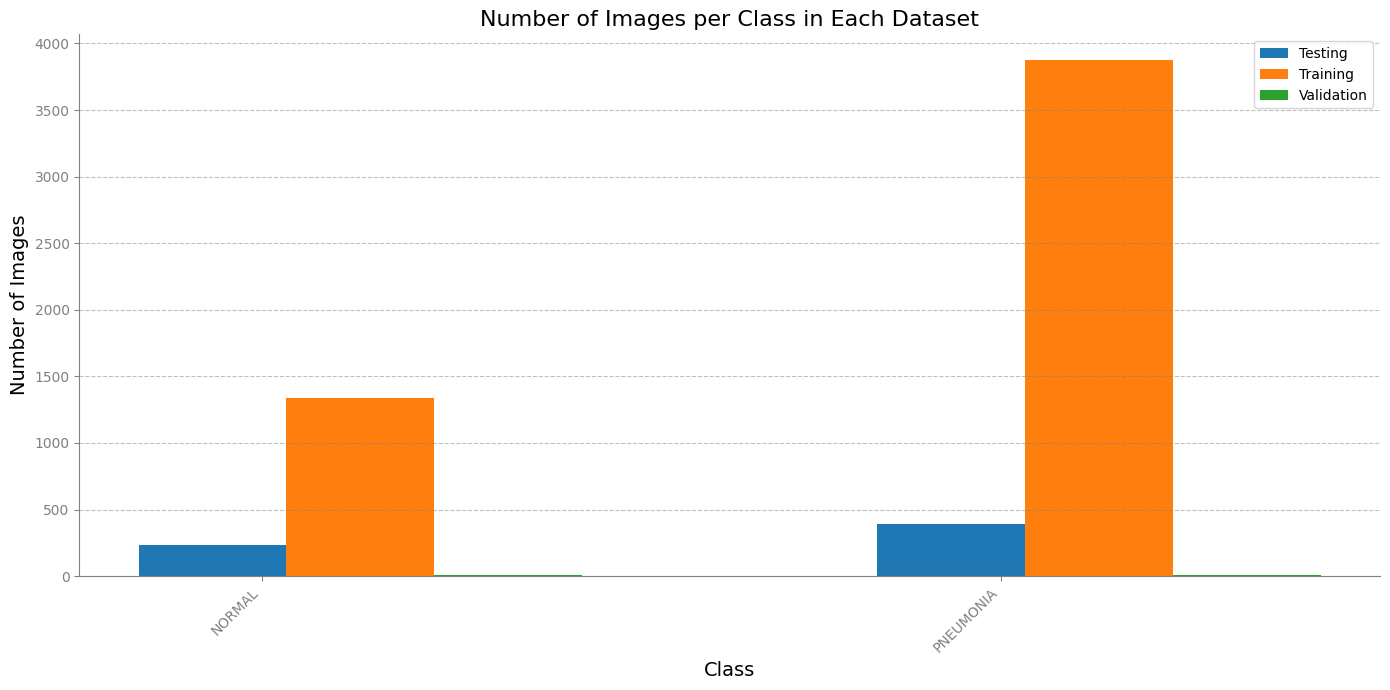

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_counts_grouped(counts):
    """
    Visualize image counts as grouped bar charts for each class across datasets.
    Args:
    - counts (dict of dicts): Image counts for each class in each dataset.
    """
    # Extract dataset names and ensure a consistent order
    datasets = sorted(counts.keys())
    # Aggregate all classes from the datasets, ensuring no duplicates
    classes = sorted(set([class_ for dataset in counts.values() for class_ in dataset.keys()]))

    # Number of dataset groups and total classes for plotting
    n_datasets = len(datasets)
    n_classes = len(classes)

    # Create an array for the x locations of the groups
    ind = np.arange(n_classes)
    # The width of the bars: can also be len(x) sequence
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 7))

    # Generate bars for each dataset
    for i, dataset in enumerate(datasets):
        dataset_counts = [counts[dataset].get(class_, 0) for class_ in classes]
        ax.bar(ind + i*width, dataset_counts, width, label=dataset)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Number of Images', fontsize=14)
    ax.set_title('Number of Images per Class in Each Dataset', fontsize=16)
    ax.set_xticks(ind + width / n_datasets)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.legend()

    # Improve the aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(colors='gray', which='both')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

visualize_counts_grouped(image_counts)


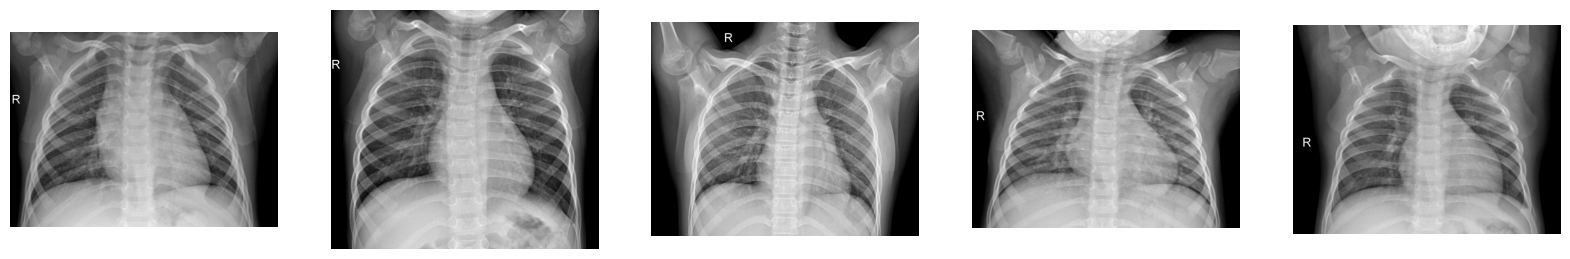

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def display_sample_images(dir, class_, num_samples=3):
    class_dir = os.path.join(dir, class_)
    sample_images = random.sample(os.listdir(class_dir), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for ax, image in zip(axes, sample_images):
        img_path = os.path.join(class_dir, image)
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

# Example usage: Display 3 sample images from the 'NORMAL' class in the training set
display_sample_images(train_dir, 'NORMAL', 5)

---
## Data Preprocessing


In [8]:
# Define constants
ROTATION_RANGE = 20
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
HORIZONTAL_FLIP = True
FILL_MODE = 'nearest'
TARGET_SIZE = (300, 300)
RESCALE = 1. / 255.
BATCH_SIZE = 32

def create_augmented_data_generator(train_dir):
    """
    Create a data generator for training images with augmentation.

    Args:
        train_dir (str): Path to the directory containing training images.

    Returns:
        DirectoryIterator: Data generator for training images with augmentation.
    """
    train_datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        fill_mode=FILL_MODE,
        rescale=RESCALE
    )

    train_data_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return train_data_generator

def create_val_data_generator(val_dir):
    """
    Create a data generator for validation images without augmentation.

    Args:
        val_dir (str): Path to the directory containing validation images.

    Returns:
        DirectoryIterator: Data generator for validation images without augmentation.
    """
    val_datagen = ImageDataGenerator(rescale=RESCALE)

    val_data_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return val_data_generator

def create_test_data_generator(test_dir):
    """
    Create a data generator for test images without augmentation.

    Args:
        test_dir (str): Path to the directory containing test images.

    Returns:
        DirectoryIterator: Data generator for test images without augmentation.
    """
    test_datagen = ImageDataGenerator(rescale=RESCALE)

    test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return test_data_generator

In [10]:
# class_weights_dict = None

In [11]:
# Call the function to create augmented data generator for training set
print("Creating augmented data generator for training set...")
train_data_generator = create_augmented_data_generator(train_dir)

# Call the function to create data generator for validation set
print("Creating augmented data generator for validation set...")
val_data_generator = create_val_data_generator(val_dir)

# Call the function to create data generator for test set
print("Creating augmented data generator for testing set...")
test_data_generator = create_test_data_generator(test_dir)

Creating augmented data generator for training set...
Found 5216 images belonging to 2 classes.
Creating augmented data generator for validation set...
Found 16 images belonging to 2 classes.
Creating augmented data generator for testing set...
Found 624 images belonging to 2 classes.


In [12]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2), input_shape=(300, 300, 3), name="First_Convolution"),
        tf.keras.layers.Dropout(rate=0.1, name='Dropout_1'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), name="Second_Convolution"),
        tf.keras.layers.Dropout(rate=0.1, name='Dropout_2'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2), name="Third_Convolution"),
        tf.keras.layers.Dropout(rate=0.1, name='Dropout_3'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                  metrics=['accuracy'])
    return model

In [13]:
# Training our model
history = model.fit(train_data_generator,
                    epochs=10,
                    batch_size=100,
                    validation_data=test_data_generator)

NameError: name 'model' is not defined

---
### References:

Varshni, D., Thakral, K., Agarwal, L., Nijhawan, R. and Mittal, A. (2019). Pneumonia Detection Using CNN based Feature Extraction. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICECCT.2019.8869364.